<h1> 5. Treniranje modela </h1>

Odabrali smo XGBoost algoritam za treniranje modela. Također ćemo dodatno isprobati metodu oversampling zbog nebalansiranosti skupa za testiranje. 

Napravit ćemo i pretraživanje parametara za parametre "max_depth", "min_child_weight" i "gamma" XGB klasifikatora.

Osim toga, isprobali smo i neuronske mreže i slučajne šume, no najbolji rezultat nam je dao XGBoost nakon pretraživanja parametara.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
## BRISE UPOZORENJA
import warnings
warnings.filterwarnings('ignore')

In [3]:
## UČITAVANJE TRAIN I TEST SKUPA - bez odabira značajki
X_train = pd.read_hdf('X_train.h5' , key = 'X_train')
X_test = pd.read_hdf('X_test.h5', key = 'X_test')
y_train = X_train['PRIJEVREMENI_RASKID'].ravel()
X_train.drop(['PRIJEVREMENI_RASKID'], axis = 1, inplace = True)


In [4]:
X_train.columns

Index(['KLIJENT_ID', 'PLANIRANA_DULJINA_KREDITA', 'PRODULJENJA', 'STAROST',
       'UGOVORENI_IZNOS', 'VISINA_KAMATE', 'ind1-poc', 'ind10-poc',
       'ind11-poc', 'ind12-poc', 'ind2-poc', 'ind3-poc', 'ind4-poc',
       'ind5-poc', 'ind6-poc', 'ind7-poc', 'ind8-poc', 'ind9-poc',
       'VRSTA_KLIJENTA_CODE', 'VALUTA_CODE', 'TIP_KAMATE_CODE',
       'PROIZVOD_CODE', 'GODINA_OTVARANJA_CODE', 'VRSTA_PROIZVODA_CODE'],
      dtype='object')

In [5]:
X_train.shape

(663500, 24)

<h3> Oversampling </h3>

In [6]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# concatenate our training data back together
X = pd.read_hdf('X_train_ft.h5' , key = 'X_train_ft')
# separate minority and majority classes
neraskidi = X[X['PRIJEVREMENI_RASKID']==0]
raskidi = X[X['PRIJEVREMENI_RASKID']==1]

# upsample minority
raskidi_upsampled = resample(raskidi,
                          replace=True, # sample with replacement
                          n_samples= len(neraskidi), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([neraskidi, raskidi_upsampled])

# check new class counts
upsampled['PRIJEVREMENI_RASKID'].value_counts()

1    543968
0    543968
Name: PRIJEVREMENI_RASKID, dtype: int64

In [7]:
y_train_up = upsampled['PRIJEVREMENI_RASKID']
X_train_up = upsampled.drop(['PRIJEVREMENI_RASKID'], axis = 1)

<h3> XGBoost </h3>

XGBoost je algoritam koji je nedavno postao domninantan u primjeni strojnog učenja na raznim natjecanjima zbog svoje brzine i performansa. Implementacija je gradient boosting-a sa stablima odlučivanja.

In [ ]:
## ukoliko nije instaliran
!pip install xgboost

In [8]:
import xgboost as xgb

In [8]:
model1 = xgb.XGBClassifier()
model2 = xgb.XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.1, subsample=0.5)

In [9]:
train_model1 = model1.fit(X_train, y_train)
train_model2 = model2.fit(X_train, y_train)

In [10]:
pred1 = train_model1.predict(X_test)
pred2 = train_model2.predict(X_test)

In [11]:
y_test = pred1
y_test = np.where(y_test==0,'N','Y')
student = pd.read_excel('eval_dataset_nan.xlsx')
student['PRIJEVREMENI_RASKID'] = y_test
student.to_csv('student.csv')

In [12]:
y_test = pred2
y_test = np.where(y_test == 0,'N','Y')
student = pd.read_excel('eval_dataset_nan.xlsx')
student['PRIJEVREMENI_RASKID'] = y_test
student.to_csv('student.csv')

<h4> Hyperparameter tuning </h4>

U ovom dijelu ćemo isprobati odabrati najbolje parametre 'max_depth', 'min_child_weight' i 'gamma'.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
rez = {'Accuracy': make_scorer(accuracy_score)}


param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test, scoring=rez, n_jobs=4,iid=False, refit = 'Accuracy' ,cv=5)

train_model4 = gsearch.fit(X_train, y_train)
pred4 = train_model4.predict(X_test)

In [10]:
gsearch.best_params_ # najbolji parametri

{'max_depth': 4, 'min_child_weight': 4}

In [11]:
gsearch.best_score_ # najbolji rezultat 

0.5817161447509701

In [12]:
print('Najbolji parametri:')
print(gsearch.best_params_)
print('\n Accuracy score s najboljim parametrima:')
print(gsearch.best_score_)

Najbolji parametri:
{'max_depth': 4, 'min_child_weight': 4}

 Accuracy score s najboljim parametrima:
0.5817161447509701


Testiranjem na web servisu se pokazalo da iako je accuracy u grid-searchu manji, rezultat na web-servisu je bolji. Naime, grid-search sa scoringom ROC-AUC krivulje daje puno viši score nego kad je scoring postavljen na 'Accuracy'. 

In [13]:
from xgboost import plot_importance


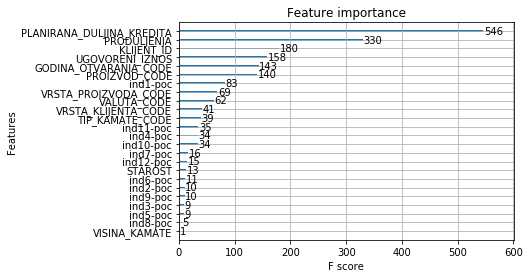

In [14]:
plot_importance(gsearch.best_estimator_)

In [15]:
## UČITAVANJE TRAIN I TEST SKUPA - prvi odabir
X_train = pd.read_hdf('X_train_ft1.h5' , key = 'X_train_ft1')
X_test = pd.read_hdf('X_test_ft1.h5', key = 'X_test_ft1')
y_train = X_train['PRIJEVREMENI_RASKID'].ravel()
X_train.drop(['PRIJEVREMENI_RASKID'], axis = 1, inplace = True)


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
rez = {'Accuracy': make_scorer(accuracy_score)}


param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test, scoring=rez, n_jobs=4,iid=False, refit = 'Accuracy' ,cv=5)

train_model4 = gsearch.fit(X_train, y_train)
pred4 = train_model4.predict(X_test)

In [17]:
print('Najbolji parametri:')
print(gsearch.best_params_)
print('\n Accuracy score s najboljim parametrima:')
print(gsearch.best_score_)

Najbolji parametri:
{'max_depth': 4, 'min_child_weight': 5}

 Accuracy score s najboljim parametrima:
0.5749640658313131


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
rez = {'Accuracy': make_scorer(accuracy_score)}


param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test, scoring='roc_auc', n_jobs=4,iid=False ,cv=5)

train_model4 = gsearch.fit(X_train, y_train)
pred4 = train_model4.predict(X_test)

In [19]:
print('Najbolji parametri:')
print(gsearch.best_params_)
print('\n ROC-AUC score s najboljim parametrima:') # za sve značajke 0.7361355976623376
print(gsearch.best_score_)

Najbolji parametri:
{'max_depth': 4, 'min_child_weight': 5}

 ROC-AUC score s najboljim parametrima:
0.7367119942746945


In [20]:
## UČITAVANJE TRAIN I TEST SKUPA - drugi odabir
X_train = pd.read_hdf('X_train_ft2.h5' , key = 'X_train_ft2')
X_test = pd.read_hdf('X_test_ft2.h5', key = 'X_test_ft2')
y_train = X_train['PRIJEVREMENI_RASKID'].ravel()
X_train.drop(['PRIJEVREMENI_RASKID'], axis = 1, inplace = True)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
rez = {'Accuracy': make_scorer(accuracy_score)}


param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test, scoring='roc_auc', n_jobs=4,iid=False ,cv=5)

train_model4 = gsearch.fit(X_train, y_train)
pred4 = train_model4.predict(X_test)

In [ ]:
print('Najbolji parametri:')
print(gsearch.best_params_)
print('\n ROC-AUC score s najboljim parametrima:')
print(gsearch.best_score_)

In [ ]:
## UČITAVANJE TRAIN I TEST SKUPA - treći odabir
X_train = pd.read_hdf('X_train_ft3.h5' , key = 'X_train_ft3')
X_test = pd.read_hdf('X_test_ft3.h5', key = 'X_test_ft3')
y_train = X_train['PRIJEVREMENI_RASKID'].ravel()
X_train.drop(['PRIJEVREMENI_RASKID'], axis = 1, inplace = True)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
rez = {'Accuracy': make_scorer(accuracy_score)}


param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test, scoring='roc_auc', n_jobs=4,iid=False ,cv=5)

train_model4 = gsearch.fit(X_train, y_train)
pred4 = train_model4.predict(X_test)

In [ ]:
print('Najbolji parametri:')
print(gsearch.best_params_)
print('\n ROC-AUC score s najboljim parametrima:')
print(gsearch.best_score_)

In [ ]:
## UČITAVANJE TRAIN I TEST SKUPA - četvrti odabir
X_train = pd.read_hdf('X_train_ft4.h5' , key = 'X_train_ft4')
X_test = pd.read_hdf('X_test_ft4.h5', key = 'X_test_ft4')
y_train = X_train['PRIJEVREMENI_RASKID'].ravel()
X_train.drop(['PRIJEVREMENI_RASKID'], axis = 1, inplace = True)


In [ ]:
print('Najbolji parametri:')
print(gsearch.best_params_)
print('\n ROC-AUC score s najboljim parametrima:')
print(gsearch.best_score_)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
rez = {'Accuracy': make_scorer(accuracy_score)}


param_test = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test, scoring='roc_auc', n_jobs=4,iid=False ,cv=5)

train_model4 = gsearch.fit(X_train, y_train)
pred4 = train_model4.predict(X_test)

In [ ]:
##ISPIS RJESENJA
y_test = pred4 # ili neki drugi rezultat estimatora
y_test = np.where(y_test==0,'N','Y')
student = pd.read_excel('eval_dataset_nan.xlsx')
student['PRIJEVREMENI_RASKID'] = y_test
student.to_csv('student.csv')

Tuning ostalih parametara

In [32]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=200, max_depth=4,
 min_child_weight=5,  gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc-auc',n_jobs=4,iid=False, cv=5)

train_model5 = gsearch2b.fit(X_train, y_train)
pred5 = train_model5.predict(X_test)

In [ ]:
##ISPIS RJESENJA
y_test = pred5
y_test = np.where(y_test==0,'N','Y')
student['PRIJEVREMENI_RASKID'] = y_test
student.to_csv('student.csv')

In [35]:
#Tune Gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring=rez, refit = 'Accuracy',n_jobs=4,iid=False, cv=5)

train_model6 = gsearch3.fit(X_train, y_train)
pred6 = train_model6.predict(X_test)



<h3> Slučajne šume </h3>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

y_test = y_pred

student = pd.read_excel('eval_dataset_nan.xlsx')
y_test = np.where(y_test==0,'N', 'Y')

student['PRIJEVREMENI_RASKID'] = y_test

student.to_csv('student.csv')

<h3> Neuronske mreže </h3>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [ ]:
!pip install numpy==1.16.3

In [57]:
X_train = pd.read_hdf('X_train_ft1.h5')
X_test = pd.read_hdf('X_test_ft1.h5')
y_train = X_train['PRIJEVREMENI_RASKID']
del X_train['PRIJEVREMENI_RASKID']

In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from keras.layers import Flatten
from keras.layers import Dropout

Using TensorFlow backend.


In [59]:
X_train.shape

(663500, 14)

In [60]:
y_train

0         0
1         0
2         0
3         0
4         0
5         1
6         0
7         0
8         1
9         1
10        1
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
663470    1
663471    1
663472    1
663473    1
663474    1
663475    1
663476    1
663477    1
663478    1
663479    1
663480    1
663481    1
663482    1
663483    1
663484    1
663485    1
663486    1
663487    0
663488    1
663489    1
663490    1
663491    1
663492    1
663493    1
663494    1
663495    1
663496    1
663497    1
663498    0
663499    1
Name: PRIJEVREMENI_RASKID, Length: 663500, dtype: int32

In [61]:
import keras
import numpy as np
np.random.seed(7)

In [ ]:
#https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-classification-3a3656c726c1
#https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2
model = Sequential()
model.add(Dense(10, input_dim=14, activation='relu', kernel_initializer='uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='uniform'))
model.add(Dense(1, activation='sigmoid'))

In [63]:
#optimizer = keras.optimizers.Adam(lr=0.00146)

In [64]:
#Compiling the neural network
model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [ ]:
model.fit(X_train,y_train, batch_size=64, epochs=2)

In [66]:
eval_model=model.evaluate(X_train, y_train)
eval_model

663500/663500 [==============================] - 7s 11us/step


[0.35720141318931153, 0.8643104747550867]

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                150       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [68]:
y_pred=model.predict(X_test)
y_pred =(y_pred>0.5)

In [69]:
y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [70]:
y_pred=1*y_pred
y_pred.shape

(84903, 1)

In [71]:
y_pred = np.where(y_pred==0,'N', 'Y')

In [72]:
y_pred

array([['N'],
       ['N'],
       ['N'],
       ...,
       ['N'],
       ['N'],
       ['N']], dtype='<U1')

In [73]:
test = pd.read_hdf('test_dataset.h5')

In [74]:
test['PRIJEVREMENI_RASKID'] = y_pred

In [ ]:
X_train = pd.read_hdf('X_train.h5')
X_test = pd.read_hdf('X_test.h5')
y_train = X_train['PRIJEVREMENI_RASKID']
del X_train['PRIJEVREMENI_RASKID']

In [ ]:
!pip install numpy==1.16.3

In [ ]:
#https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-classification-3a3656c726c1
#https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2
model = Sequential()
model.add(Dense(10, input_dim=14, activation='relu', kernel_initializer='uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='uniform'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
#Compiling the neural network
model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [ ]:
model.fit(X_train,y_train, batch_size=64, epochs=2)

In [ ]:
eval_model=model.evaluate(X_train, y_train)
eval_model